In [50]:
import numpy as np
import pandas as pd
import json
import csv
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [52]:
# importing data for which speaker names have already been cleaned
qtes_just_names = pd.read_csv("/content/drive/MyDrive/data/qtes_just_names.csv")

In [53]:
# Reading gni88.json to a Pandas df
arts = pd.read_json("/content/drive/MyDrive/data/gni88.json", lines=True)

# Definining Speaker Categories

In [54]:
# dictionary containing the classification groups for all speaker types
source_groups = {"Foreign Government": ['Foreign Gov/Mil Official'],
                "Experts": ['Nuke Organization','Non-Profit/NGO','Think Tanks',
                            'Nuke Organization - Other', 'Nuke Organization - Academic',
                            'International Orgs','Academic','Nuclear Scientist',"Analyst/Commentator",
                            'Attorney','Regulator'],
                "US Congress": ['US Rep. & Staff','US Senate & Staff', 'Partisans/Fmr. Politicians'],
                "US Federal Officials": ['Federal Official','State/Local Official',
                                        'Former Admin. Officials','Judicial Official'],
                "US Defense": ['US Military','Defense Forces','Defense'],
                "Media": ["Media/Journalist","Blogger"],
                "Corporate Official": ['Corporate Official'],
                "Other": ['Other','Chairman','Terrorist/Extremist','Information minister',
                          'Religious/Clerical', 'Ambassador', 'Nuclear Official',
                          'Citizen','Public Polling','US Police','Deputy']}

In [55]:
# Helper function that inverts a dictionary. This will be useful for using speaker groups
# later on in model evaluation
def invert_dict(dictionary):
  """Inputs:
     - dictionary: dict, dictionary we wish to invert
     Outputs:
     - dict, where keys are the initial dictionary's values and values are the initial dictionary's keys"""
  # get a list of all items in all dictionary values
  speaker_types = list(np.concatenate(list(dictionary.values())).flat)
  # each speaker type will become its own key now, and the value will be the speaker group it's a part of
  inverted_dict = {}
  for speaker_type in speaker_types:
    # find the group the speaker_type belongs in
    speaker_group = [key for key, value in dictionary.items() if speaker_type in value][0]
    # update the inverted dictionary such that the key is the speaker type and the value is the speaker group
    inverted_dict[speaker_type] = speaker_group
  return inverted_dict

In [56]:
# creating an inverted dictionary to help with creating a speaker category column in our df
source_to_group = invert_dict(source_groups)

# Context Extraction Setup

See context extraction notebooks elsewhere in the repo for a more in-depth explanation of how these work

In [57]:
# NLTK will be useful for parsing context sentences. We rely on an understanding of
# what words are nouns in order to extract certain context patterns

# Instructions: Downloader will prompt a response. Respond as follows:
# - d   (and enter)
# - all (and enter)
# - q   (and enter)
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Package abc is already up-to-date!
       | Downloading package alpino to /root/nltk_data...
       |   Package alpino is already up-to-date!
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger is already up-to-date!
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Package averaged_perceptron_tagger_ru is already up-to-
       |       date!
       | Downloading package basque_grammars to /root/nltk_data...
       |   Package basque_grammars is already up-to-date!


True

In [58]:
# More NLTK setup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english'))

In [59]:
# helper function to extract full article text, useful for debugging cases where the context extraction function fails
def content_of(art_id):
  """Inputs:
     - art_id: id of the article to get the full text of
     Outputs:
     - str: the full article content as a string"""
  just_id = arts[arts["Article ID"] == art_id]["Content"]
  if len(just_id) > 0:
    return arts[arts["Article ID"] == art_id]["Content"].iloc[0]
  else: 
    return ""

In [60]:
# Helper function to find the context for a speaker if the context follows a prenoun pattern
# Example: "Russian president Vladimir Putin" -- useful context nouns "Russian president" precede Putin's name
def find_prenoun_pattern(name, mentions):
  """Inputs:
     - name: str, name of the speaker we're looking for context for
     - mentions: list of str, all paragraphs in the article where name has appeared
     Outputs:
     - str: the prenoun context preceding a name's mention, if it exists. If no prenoun
            context is found, return an empty string."""
  # listing pos tags we can reference
  nouns = ['NN','NNS','NNP','NNPS']
  verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
  adverbs = ['RB','RBR','RBS']
  # get last name and name length (num words in name) for reference
  last_name = name.split()[-1]
  name_len = len(name.split())
  # for each sentence in the article that name appears in:
  for mention in mentions:
    potential_verb = ""
    # tokenize the sentence and parse it to see what part of speech (pos)
    # every word in it is
    wordsList = nltk.word_tokenize(mention) # note: we're keeping stopwords
    tagged = nltk.pos_tag(wordsList)
    if len(tagged) <= 1:
      return ""
    # now we iterate through the sentence
    sentence_legend = {}
    name_idx = 0
    i = 0
    # for each word in sentence:
    for tag_pair in tagged:
      sentence_legend[i] = tag_pair
      # if we find the last name, save that word index. It'll be handy
      if tag_pair[0] == last_name:
        name_idx = i
      i += 1
      
    # using the word index of the name, go back in the sentence to find the
    # word preceding it. If that preceding word is a noun, we have a prenoun
    # pattern we should extract! (we know it's a noun because of NLTK functionality)
    if name_idx - name_len >= 0:
      preceding_word_pos = sentence_legend[name_idx-name_len][1] 
      if preceding_word_pos in nouns:
        prenoun_pattern = ".*?((?:\w+\W+){1,4})" + name
        matches = re.search(prenoun_pattern, mention)
        if matches:
          #print(mention)
          return matches[1]
  return ""

In [61]:
# hardcoded list of names that are so recognizable that they often lack context.
# we will search for them manually so as not to confuse the algorithm with noisy context
household_names = ['donald trump','barack obama','ayatollah ali khameni',
                   'vladimir putin','kim jong un', 'joe biden', 'joseph biden', 
                   'george bush', 'benjamin netanyahu', "mitt romney"]

In [62]:
# Beefed up context extraction function that searches for many more possible context patterns
def fancy_context(art_id, name, verbose=False):
  """Inputs:
     - art_id: int, id of the article in which name spoke a quote
     - name: str, name of the speaker to search for context for
     - verbose: bool, whether or not to print a log of what patterns
                were found
     Outputs:
     - str: relevant context that can help identify name in article art_id.
            if no patterns could be matched, this string will be NO CONTEXT FOUND.
            if name is a household name, return the name alone. We have an indicator
            to handle it later."""
  content = content_of(art_id)
  # standardize article content and name to make searching easier
  content = content.lower()
  content = content.replace("-"," ")
  content = re.sub(' \w\. ',' ',content) # remove middle initials
  content = content.replace("'","")
  name = name.lower()
  name = name.replace("-", " ")
  name = name.replace("'", "")
  # initial hardcoded check for household names, since these names often don't
  # have any context and will only confuse the algorithm
  if name in household_names:
    if verbose:
      print("HOUSEHOLD NAME PATTERN")
    return name
  last_name = name.split()[-1]

  # split the full text into a list of paragraphs
  paragraphs =  re.split(r"\n", content)
  # find paragraphs where the name is mentioned
  mentions = []
  for paragraph in paragraphs:
    if name in paragraph:
      mentions.append(paragraph)
  
  # BEGIN PATTERN MATCHING
  #writer_pattern1 = '(author\:? |by\:? )' + name
  writer_pattern1 = '(author\:? )' + name
  #writer_pattern2 = '(\n' + name + '.{0,10}\n)'
  writer_pattern2 = name+'   \r'
  congress_pattern = '(\w{3}. ' + name + ' \([dr]{1} .+\))'
  precontext_pattern = '([,\.!?].+, )' + name
  is_pattern = name + ' (is .+[,\.!?])'
  postcontext_pattern = name + '(,.+[,\.!?])'
  catchall_pattern = '(\W+(?:\w+\W+){0,6}' + name + '\W+(?:\w+\W+){0,12})'
  context = ""

  # try writer pattern (E: 'By: Johnny Harris')
  for mention in mentions:
    matches = re.search(writer_pattern1, mention)
    if matches:
      context = matches[1]
      break
    matches = re.search(writer_pattern2, mention)
    if matches:
      context = "media_tag"
      break
  if context:
    if verbose:
      print("WRITER PATTERN")
    return context

  # try congress pattern (E: 'sen. John McCain (r ariz.))
  for mention in mentions:
    matches = re.search(congress_pattern, mention)
    if matches:
      context += matches[1]
  if context:
    if verbose:
      print("CONGRESS PATTERN")
    return context

  # try prenoun pattern (E: 'Press secretary Jen Psaki')
  prenoun_result = find_prenoun_pattern(name, mentions)
  if prenoun_result:
    if verbose:
      print("PRENOUN PATTERN")
    return prenoun_result

  # try precontext patterns (E: 'Director of international affairs, Rob Black')
  for mention in mentions:
    matches = re.search(precontext_pattern, mention)
    if matches:
      context += matches[1]
  if context:
    if verbose:
      print("PRECONTEXT PATTERN")
    return context

  # try is pattern (E: 'Ezra Klein is a writer for the New York Times')
  for mention in mentions:
    matches = re.search(is_pattern, mention)
    if matches:
      context += matches[1]
  if context:
    if verbose:
      print("IS PATTERN")
    return context

  # try postcontext pattern (E: 'Daniel Chung, a researcher for ReThink media, ...')
  for mention in mentions:
      matches = re.search(postcontext_pattern, mention)
      if matches:
        context += matches[1]
  if context:
    if verbose:
      print("POSTCONTEXT PATTERN")
    return context

  # if all else fails, extract the first few words both preceding and trailing mentions
  # of name in the article. A less surgical extraction, but still an extraction.
  for mention in mentions:
      matches = re.search(catchall_pattern, mention)
      if matches:
        context += matches[1]
        break
  if context:
    if verbose:
      print("CATCHALL FOR " + str(art_id) + ", " + name)
    return context

  # if all else REALLY fails, run the whole function again with just the speaker's
  # last name, since sometimes they are mentioned as "Mr. last_name" or "Mrs. last_name"
  if len(name.split()) > 1:
    if verbose:
      print("RERAN CONTEXT EXTRACTION ON LAST NAME")
    return fancy_context(art_id, last_name)
  else:
    context = "# NO CONTEXT FOUND #"
    if verbose:
      print("NO PATTERN FOUND FOR " + str(art_id) + ", " + name)
    return context

# Aggregating context clues by speaker category

Want: a dictionary where keys are speaker categories and the values are combined strings of all contexts extracted from speakers in that category. This is useful because we can look at these long blocks of combined context and directly compare them between different speaker categories.

In [63]:
# initialize result dictionary, where keys are speaker groups and values are the 
# giant text blocks of context associated with the quotes in each group
results_dict = {}
# initialize counts dictionary, where keys are speaker groups and values are the
# counts of quotes that constituted the text blocks in the results_dict for that 
# speaker group
counts_dict = {}

for group in source_groups.keys():
  results_dict[group] = ""
  counts_dict[group] = 0

i = 0
# IMPORTANT: there are too many quotes to do this all at once, so we take
# a random sample of 1500 quotes from the quotes dataframe to work with,
# filter so we are only dealing with real names
qtes_sample = qtes_just_names.sample(n=1500)
# for each quote:
for index, qte in qtes_sample.iterrows():
  # get info neded to find context
  art_id = qte["Article ID"]
  name = qte["cleaned_name"]
  # get classification info about speaker group
  quote_source = qte["Source Type"]
  if type(quote_source) == str:
      quote_group = source_to_group[quote_source]
  else: 
    quote_group = "Other"
  # now actually get the context
  context = fancy_context(art_id, name, verbose=False)
  if context not in results_dict[quote_group]:
    results_dict[quote_group] = results_dict[quote_group] + " ||| [" + str(art_id) + ", " + name + "] " + context
    counts_dict[quote_group] = counts_dict[quote_group] + 1

# Defining Features

In [64]:
# Listing indicidator features to compare across the speaker categories
experts_ps = ["associate professor",
              "university",
              "studies",
              "scholar",
              "expert",
              "historian",
              "academy",
              "social science",
              "lecturer",
              "physicist",
              "professor",
              "political science",
              "political",
              "scientist",
              "college",
              "education",
              "school",
              "economics",
              "international relations",
              "physics",
              "associate professor",
              "researcher",
              "laboratory",
              "research fellow",
              "graduate school",
              "international affairs",
              "research associate",
              "dr\.",
              "ph\.d\.",
              "institute of technology",
              "economist",
              "analysis",
              "counselor",
              "postdoctoral",
              "fellow",
              "specialist",
              "novelist",
              "founder",
              "council",
              "director",
              "program",
              "think tank",
              "foundation",
              "institute",
              "division",
              "policy",
              "association",
              "center",
              "group",
              "superindendent",
              "international"]
foreign_gov_ps = ["putin|kim jong un|netanyahu|ayatollah|moon jae in",
                  "[nseih] president",
                  "[nseih] foreign",
                  "foreign minister",
                  "foreign ministry",
                  "prime minister",
                  "people's liberation army",
                  "foreign policy",
                  "supreme leader",
                  "prince"] 
corporate_official_ps = ["chief finnancial officer",
                         "managing director",
                         "bank",
                         "chief executive",
                         "general manager",
                         "investment fund",
                         "investment",
                         "employer",
                         "firm",
                         "chief executive officer",
                         "businessman",
                         "businesswoman",
                         "inc\.",
                         "manager",
                         "ltd[ ,\.]",
                         "chairman",
                         "chairwoman",
                         "sales",
                         "managing",
                         "program director",
                         "strategist",
                         "company",
                         "contractor",
                         "consultancy"]
judicial_ps = ["attorney",
               "justice",
               "lawyer",
               "court",
               "judge",
               "magistrate"]
us_congress_ps = [" sen\.",
                  " rep\.",
                  " sens\.",
                  " reps\.",
                  " r ",
                  " d ",
                  "\(r",
                  "\(d",
                  "democrat",
                  "democratic",
                  "republican",
                  "majority leader",
                  "minority leader",
                  "senate",
                  "house",
                  "committee",
                  "frontrunner",
                  "candidate",
                  "committee chairman",
                  "ranking member",
                  " top",
                  "foreign relations committee",
                  "intelligence committee",
                  "hopeful",
                  "house speaker",
                  "campaign"]
us_defense_ps = ["pentagon",
                 "navy",
                 "air force",
                 "army",
                 "marine",
                 "coast gaurd",
                 " capt\.",
                 "captain",
                 " gen\.",
                 "general",
                 " adm\.",
                 "admiral",
                 " col\.",
                 "colonel",
                 " lt\.",
                 "lieutenant",
                 "chief of staff",
                 "joint chiefs of staff",
                 "commander",
                 "norad",
                 "northcom",
                 "special forces",
                 "strategic command",
                 "defense secretary",
                 "nato",
                 "allied",
                 "officer",
                 "corps",
                 " u\.s\.",
                 " us "]
us_fed_officials_ps = ["biden|trump|obama|bush|clinton|reagan",
                        "ambassador",
                        "u\.s\. president",
                        "department",
                        "attorney",
                        "secretary of",
                        "us ambassador",
                        "state department",
                        "national security",
                        "secretary",
                        "secretary of"]
media_ps = ["author\:? ",
            "correspondent",
            "columnist",
            " post",
            " host",
            "editor",
            "times",
            "press",
            "magazine",
            "msnbc|cnn|fox",
            "writer",
            "syndicated columnist",
            "editorial",
            "blog",
            ": .+",
            "i\"m",
            "by\:? ",
            "media_tag"] 
international_officials_ps = ["deputy director general",
                              "international atomic energy agency",
                              "iaea",
                              "inspector",
                              "inspections"]
other_ps = ["hezbollah",
            "taliban",
            "pollster",
            "archbishop",
            "pope",
            "bishop",
            "church",
            "rev\.",
            "reverand",
            "police",
            "commissioner",
            "nypd",
            "resident"]

In [65]:
indicator_pattern_set  = [experts_ps,
                          foreign_gov_ps,
                          corporate_official_ps,
                          judicial_ps,
                          us_congress_ps,
                          us_defense_ps,
                          us_fed_officials_ps,
                          media_ps,
                          international_officials_ps,
                          other_ps]

In [66]:
# consolidating all indicator patterns into one list
indicator_patterns = []
for pattern_group in indicator_pattern_set:
  indicator_patterns += pattern_group

### Special indicator feature for foreign titles

In [67]:
# A special indicator to try is the existence of a foreign title--that is, any case in which
# a title and a foreign country are mentioned in the same string. Examples are shown below.
def has_foreign_title(context_str):
  """Inputs:
     - context_str: string to find a foreign title in
     Outputs:
     - int, whether or not a foreign title is in the string"""
  country_pattern = "iran|iraq|south korea|north korea|russia|china|france|germany|india|pakistan|libya|britain|u\.k\.|united kingdom|israel|saudi arabia"
  country_s_pattern = "(iran|iraq|south korea|north korea|russia|china|france|germany|india|pakistan|libya|britain|u\.k\.|united kingdom|israel|saudi arabia|south|north|korea).?s"
  country_adj_pattern = "iranian|iraqi|south korean|north koren|russian|chinese|french|german|indian|pakistani|libyan|british|israeli|saudi"
  title_pattern = "foreign|defense|minister|ambassador|leader|president|prince|diplomat|prime minister|spokesman|spokeswoman|gen\.|governor|chief|government"
  country_match = re.search(country_pattern, context_str)
  s_match = re.search(country_s_pattern, context_str)
  adj_match = re.search(country_adj_pattern, context_str)
  title_match = re.search(title_pattern, context_str)
  has_country = False 
  has_title = False
  if s_match or adj_match or country_match:
    has_country = True
  if title_match:
    has_title = True
  return int(has_country and has_title)

# Comparing relative frequencies of features between speaker category contexts

In [68]:
# helper function, takes a regex pattern, a block of text, and returns how many 
# times that pattern has a match in the text
def count(pattern, text):
  if pattern == "foreign_title":
    return has_foreign_title(text)
  match = re.findall(pattern, text)
  if match:
    return len(match)
  else:
    return 0

In [69]:
# helper function that adds a feature to the featurization dataframe.
# limited to features that count how many times a certain regex expression 
# occurs in a block of text, proportional to the relative frequency of that
# speaker type
def add_feature_freq_col(df, feature_pattern, col_name):
  freqs = []
  for group in df["Group"]:
    text = results_df[results_df["Group"] == group]["Combined Context"].iloc[0]
    #print(str(count(feature_pattern, text)) + "   " + str(counts_dict[group]))
    raw_count = count(feature_pattern, text) # how many times that pattern shows up
    adjustment = counts_dict[group] # how many quotes were in the sample
    if adjustment == 0:
      adjustment += 0.01
    freq = np.round(raw_count / adjustment, 2)
    freqs.append(freq)
  df[col_name] = freqs

In [70]:
# turning the result of this context retrieval into a dataframe for easier manipulation
results_df = pd.DataFrame()
results_df["Group"] = results_dict.keys()
results_df["Combined Context"] = results_dict.values()

In [71]:
# adding each indicator's relative frequency data to the feature matrix
for indicator_pattern in indicator_patterns + ['foreign_title']:
  add_feature_freq_col(results_df, indicator_pattern, indicator_pattern)

In [72]:
# last df cleaning
results_df = results_df.drop("Combined Context", 1)
results_df = results_df.set_index("Group")
results_df = results_df.rename(columns={"biden|trump|obama|bush|clinton|reagan":"us_president_name",
                                        "putin|kim jong un|netanyahu|ayatollah|moon jae in":"common_foreign_leader",
                                        "msnbc|cnn|fox|reuters":"news_outlet_name"})
results_df_transpose = results_df.T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


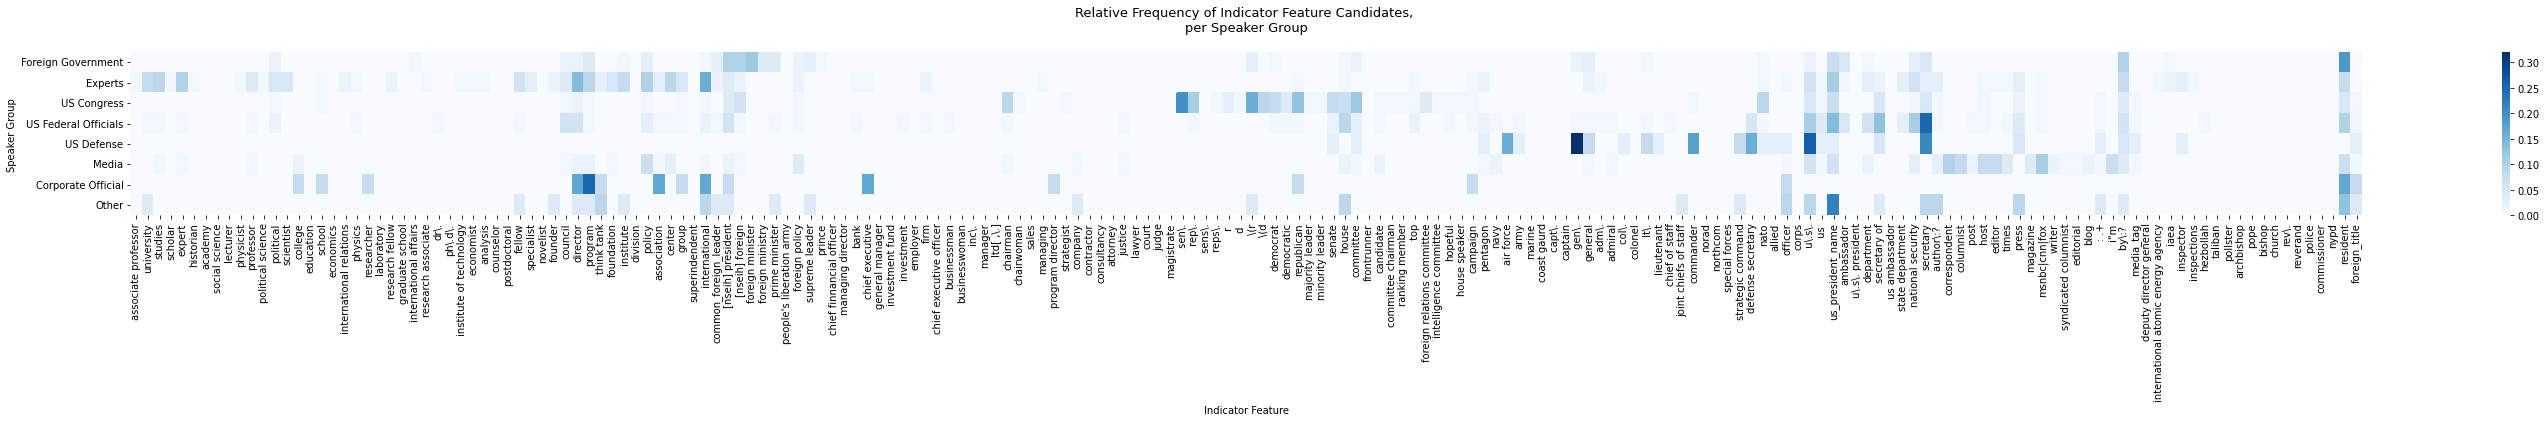

In [73]:
# horizontal heatmap of relative feature frequency between speaker categories
plt.figure(figsize=[50, 3]);
sns.heatmap(results_df, cmap="Blues");
plt.title("Relative Frequency of Indicator Feature Candidates, \nper Speaker Group\n", fontsize=13);
plt.ylabel("Speaker Group");
plt.xlabel("Indicator Feature");

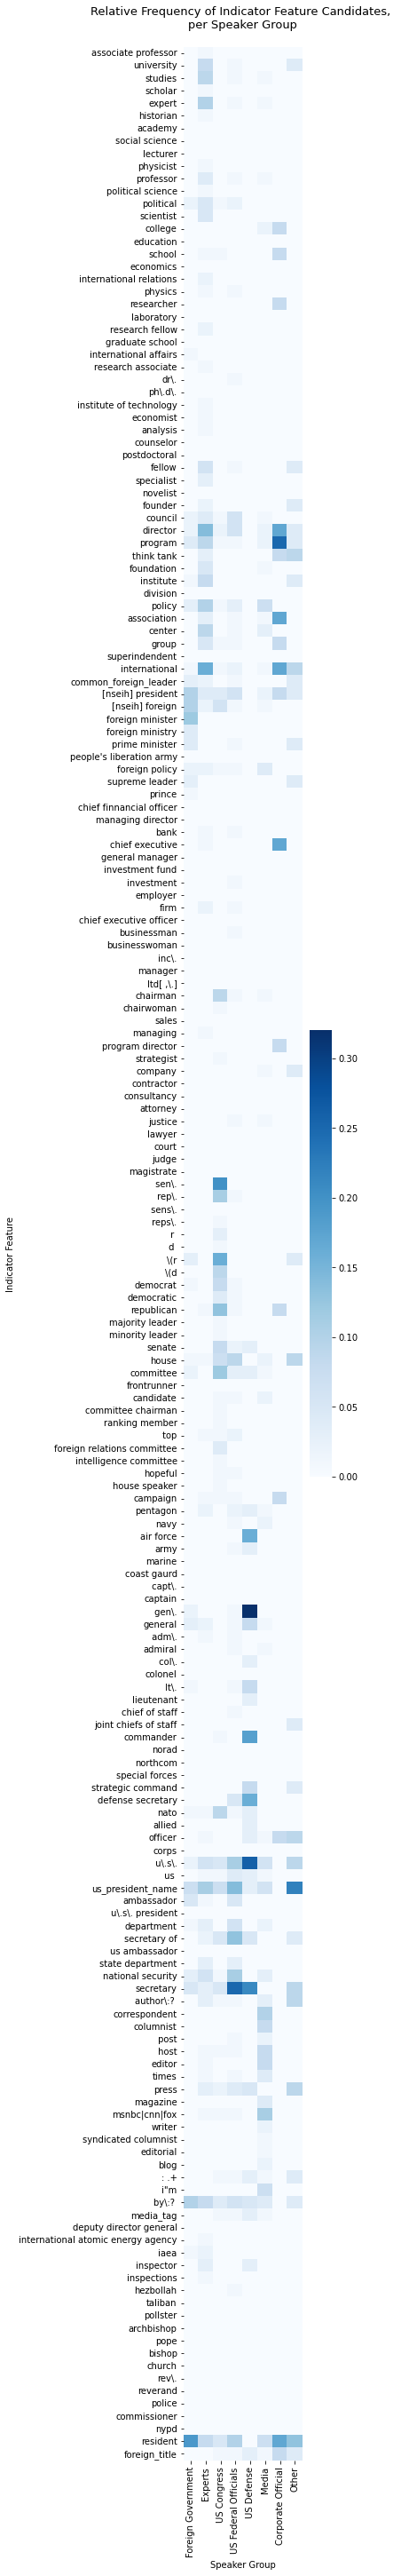

In [74]:
# vertical heatmap of relative feature frequency between speaker categories
plt.figure(figsize=[3, 50]);
sns.heatmap(results_df_transpose, cmap="Blues");
plt.title("Relative Frequency of Indicator Feature Candidates, \nper Speaker Group\n", fontsize=13);
plt.xlabel("Speaker Group");
plt.ylabel("Indicator Feature");